In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from deepxde.backend import tf

Using backend: tensorflow.compat.v1

2023-02-21 19:03:14.161664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 19:03:14.253286: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-21 19:03:14.698056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alonsolml/mambaforge/envs/pinn/

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-02-21 19:03:15.232397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-21 19:03:15.249808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-21 19:03:15.249883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:

ub = 200
rb = 20


def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true


def ode_system(x, y):
    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]


geom = dde.geometry.TimeDomain(0.0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

In [3]:

# Backend tensorflow.compat.v1 or tensorflow
def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )

# hard constraints: x(0) = 100, y(0) = 15
# Backend tensorflow.compat.v1 or tensorflow
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return tf.concat([y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1)


net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

Compiling model...
Building feed-forward neural network...
'build' took 0.070769 s



/home/alonsolml/mambaforge/envs/pinn/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-02-21 19:03:16.214593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 19:03:16.216315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-21 19:03:16.216379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file t

'compile' took 1.052694 s

Initializing variables...
Training model...



2023-02-21 19:03:17.206800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-02-21 19:03:17.302008: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f34b0004bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-21 19:03:17.302034: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-02-21 19:03:17.310715: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-21 19:03:18.072067: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-21 19:03:18.548105: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion_2', 424 bytes spill stor

Step      Train loss              Test loss               Test metric
0         [4.03e+02, 8.42e+00]    [4.03e+02, 8.43e+00]    []  


2023-02-21 19:03:20.330984: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:325] ptxas warning : Registers are spilled to local memory in function 'fusion_2', 424 bytes spill stores, 524 bytes spill loads



1000      [2.32e+00, 6.83e-01]    [2.22e+00, 6.75e-01]    []  
2000      [1.24e+00, 6.18e-01]    [1.17e+00, 6.05e-01]    []  
3000      [1.62e+01, 2.06e+00]    [1.60e+01, 2.06e+00]    []  
4000      [5.90e+00, 5.41e-01]    [5.76e+00, 5.42e-01]    []  
5000      [3.90e+00, 5.37e-01]    [3.77e+00, 5.34e-01]    []  
6000      [2.74e+00, 6.51e-01]    [2.63e+00, 6.45e-01]    []  
7000      [1.95e+00, 7.03e-01]    [1.86e+00, 6.92e-01]    []  
8000      [1.46e+00, 6.55e-01]    [1.39e+00, 6.42e-01]    []  
9000      [1.03e+00, 5.69e-01]    [9.83e-01, 5.56e-01]    []  
10000     [7.14e-01, 4.68e-01]    [6.81e-01, 4.57e-01]    []  
11000     [5.33e-01, 4.46e-01]    [5.13e-01, 4.37e-01]    []  
12000     [4.60e-01, 3.48e-01]    [4.48e-01, 3.40e-01]    []  
13000     [3.28e-01, 3.23e-01]    [3.21e-01, 3.16e-01]    []  
14000     [3.08e-01, 2.82e-01]    [3.04e-01, 2.76e-01]    []  
15000     [2.69e-01, 2.00e-01]    [2.66e-01, 1.96e-01]    []  
16000     [3.36e+00, 8.41e-01]    [3.30e+00, 8.40e-01] 

2023-02-21 19:07:14.427744: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Step      Train loss              Test loss               Test metric
50000     [9.38e-03, 1.85e-03]    [9.36e-03, 1.85e-03]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.001583
  Number of iterations: 11
  Number of functions evaluations: 36
50036     [6.96e-04, 8.86e-04]    [6.87e-04, 8.81e-04]    []  

Best model at step 50036:
  train loss: 1.58e-03
  test loss: 1.57e-03
  test metric: []

'train' took 3.148508 s

Saving loss history to /mnt/d/Documents/git/teaching-ml-diffeq/loss.dat ...
Saving training data to /mnt/d/Documents/git/teaching-ml-diffeq/train.dat ...
Saving test data to /mnt/d/Documents/git/teaching-ml-diffeq/test.dat ...


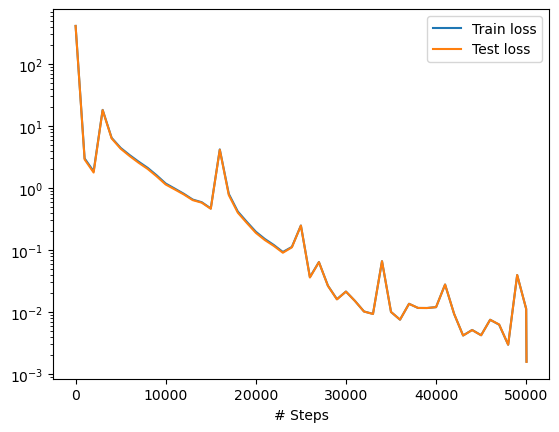

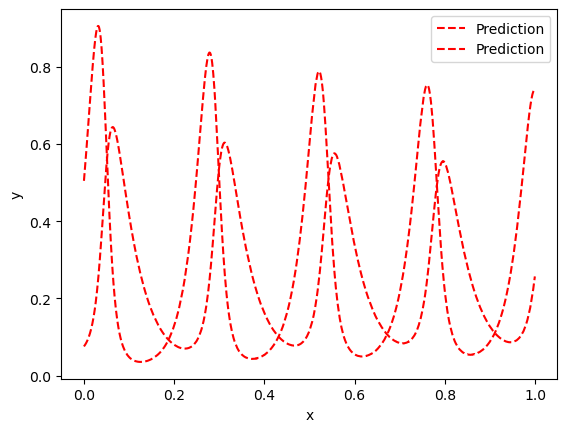

In [4]:

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


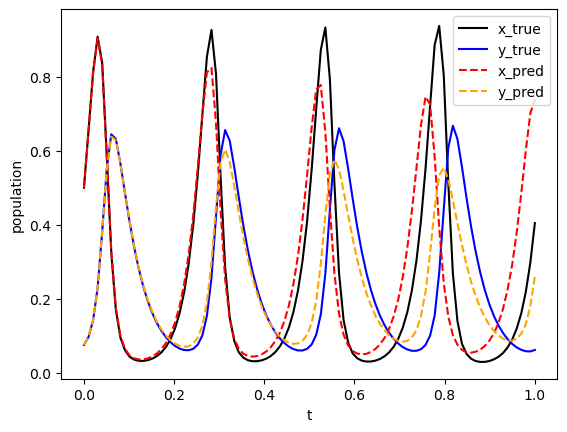

In [5]:

plt.xlabel("t")
plt.ylabel("population")

t = np.linspace(0, 1, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()